<a href="https://colab.research.google.com/github/mancudEOM/Ensemble-deep-learning/blob/main/model_5fold_DNMv2_10575325.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
  from google.colab import drive
  drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
  !ls


drive  sample_data


In [3]:
  import sys
  root_path = '/content/drive/My Drive/Mulberry Leaf Dataset/' # This is the path to where in google drive the code is stored!
  sys.path.append(root_path)

# THÊM TẤT CẢ CÁC THƯ VIỆN CẦN THIẾT

In [4]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from PIL import Image
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import warnings
import os
import shutil
from PIL import ImageFile
warnings.simplefilter('error', Image.DecompressionBombWarning)
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 1000000000
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Khởi tạo các biến cần thiết

In [5]:
datasetFolderName=root_path+'dataset'
MODEL_FILENAME=root_path+"model_cv.h5"
sourceFiles=[]
classLabels=['01 ChiangMai60','02 RedKing','03 WhiteKing',
             '04 BlackOodTurkey','05 TaiwanStraberry','06 BlackAustralia',
             '07 Buriram60','08 Kamphaengsaeng42','09 TaiwanMeacho','10 ChiangMaiBuriram60']
X=[]
Y=[]

img_rows, img_cols =  224, 224
# input image dimensions
#img_rows, img_cols =  224, 224 # input image dimensions
train_path=datasetFolderName+'/train/'
validation_path=datasetFolderName+'/validation/'
test_path=datasetFolderName+'/test/'

# KFOLD train-test-validation

In [6]:
def transferBetweenFolders(source, dest, splitRate):
    global sourceFiles
    sourceFiles=os.listdir(source)
    if(len(sourceFiles)!=0):
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")

def transferAllClassBetweenFolders(source, dest, splitRate):
    for label in classLabels:
        transferBetweenFolders(datasetFolderName+'/'+source+'/'+label+'/',
                               datasetFolderName+'/'+dest+'/'+label+'/',
                               splitRate)

In [7]:
transferAllClassBetweenFolders('test', 'train', 1.0)

In [8]:
transferAllClassBetweenFolders('validation', 'train', 1.0)

In [9]:
transferAllClassBetweenFolders('train', 'test', 0.20)

In [10]:
def prepareNameWithLabels(folderName):
    sourceFiles=os.listdir(datasetFolderName+'/train/'+folderName)
    for val in sourceFiles:
        X.append(val)
        for i in range(len(classLabels)):
          if(folderName==classLabels[i]):
              Y.append(i)

In [11]:
# Organize file names and class labels in X and Y variables
for i in range(len(classLabels)):
  prepareNameWithLabels(classLabels[i])

In [12]:
X=np.asarray(X)
Y=np.asarray(Y)

In [13]:
print(X)
print(Y)

['20191207_134315.jpg' '20191207_135618.jpg' '20191207_132738.jpg' ...
 'DSC_0201.JPG' 'DSC_0377.JPG' 'DSC_0405.JPG']
[0 0 0 ... 9 9 9]


In [14]:
batch_size = 16
IMG_SIZE = (224, 224, 3)
number_of_class_labels = len(classLabels)

In [15]:
import tensorflow.keras as keras

In [16]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential(
    [
        keras.layers.Rescaling(1./ 255),
        keras.layers.RandomFlip(),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomZoom(0.2,0.3)
    ]
)

In [17]:
#pre_trained_layers = keras.applications.ResNet50V2(weights="imagenet", include_top=False,
#           input_tensor=keras.Input(shape=IMG_SIZE))

In [18]:
#pre_trained_layers = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False,
#            input_tensor=keras.Input(shape=IMG_SIZE))

In [19]:

#pre_trained_layers = keras.applications.Xception(weights="imagenet", include_top=False,
#         input_tensor=keras.Input(shape=IMG_SIZE))

In [20]:
#pre_trained_layers = tf.keras.applications.InceptionV3(weights="imagenet", include_top=False,
#           input_tensor=keras.Input(shape=IMG_SIZE))

In [21]:
#pre_trained_layers.summary()


In [22]:

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
from keras.models import Model
from keras.layers import Input, Dense
import tensorflow as tf

In [23]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w1, w2, w3, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1] + self.w3 * inputs[2]

In [24]:
# Disable scientific notation for clarity
np.set_printoptions(suppress=True)
# Load the model
model_1 =load_model(root_path+"model_5fold_DenseNet121_16e3.h5",
                    compile=False)
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='model_5fold_DenseNet121_16e3')
model_2 = load_model(root_path+"model_5fold_NASNetMobile_16e3.h5",
                     compile=False)
model_2 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='model_5fold_NASNetMobile_16e3')
model_3 = load_model(root_path+"model_5fold_MobileNetV2_16e3_5.h5",
                     compile=False)
model_3 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='model_5fold_MobileNetV2_16e3_5')
models = [model_1, model_2, model_3]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
#ensemble_output = Average()(model_outputs)
ensemble_output = WeightedAverageLayer(0.1, 0.575, 0.325)(model_outputs)
ensemble_model= Model(inputs=model_input, outputs=ensemble_output, name='ensemble')


In [25]:

#Creating custom model



In [26]:
EPOCHS = 5
LR = 1e-3
ensemble_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [27]:
#printing summary of custom model
#ensemble_model.build((1,224,224,3))
#ensemble_model.summary()

In [28]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [29]:
# Callback -> Reduce Learning Rate on Plateau
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto',
                             min_delta=0.000001, cooldown=0, min_lr=0.000001)

In [30]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(X, Y)
fold_num = 0
for train_index, val_index in skf.split(X, Y):
    # First cut all images from validation to train (if any exists)
    transferAllClassBetweenFolders('validation', 'train', 1.0)
    fold_num += 1
    print("Results for fold", fold_num)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    # Move validation images of this fold from train folder to the validation folder
    for each_index in range(len(X_val)):
        class_label = ''
        for i in range(len(classLabels)):
            if(Y_val[each_index] == i):
                class_label = classLabels[i]
        # Then, copy the validation images to the validation folder
        shutil.move(os.path.join(datasetFolderName, 'train', class_label, X_val[each_index]),
                    os.path.join(datasetFolderName, 'validation', class_label, X_val[each_index]))



    # Start ImageClassification Model
    #creating train data set

    train_generator = tf.keras.utils.image_dataset_from_directory(
        train_path,
        image_size=(IMG_SIZE[0], IMG_SIZE[1]),
        batch_size=batch_size,
        )

    validation_generator = tf.keras.utils.image_dataset_from_directory(
        validation_path,
        image_size=(IMG_SIZE[0], IMG_SIZE[1]),
        batch_size=batch_size,

          # only data, no labels
        shuffle=False
        )

    history = ensemble_model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, callbacks=callback)
    ensemble_model.evaluate(validation_generator)

No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
Results for fold 1
Found 3368 files belonging to 10 classes.
Found 843 files belonging to 10 classes.
Epoch 1/5
211/211 [==============================] - 245s 647ms/step - loss: 0.3676 - accuracy: 0.8658 - val_loss: 3.0883 - val_accuracy: 0.6251 - lr: 0.0010
Epoch 2/5
211/211 [==============================] - 126s 594ms/step - loss: 0.3124 - accuracy: 0.8913 - val_loss: 1.1114 - val_accuracy: 0.7295 - lr: 0.0010
Epoch 3/5
211/211 [==============================] - 126s 593ms/step - loss: 0.2846 - accuracy: 0.8996 - val_loss: 1.1235 - val_accuracy: 0.7556 - lr: 0.0010
Epoch 4/5
211/211 [==============================] - 126s 593ms/step - loss: 0.3422 - accuracy: 0.8777 - val_loss: 0.7694 - val_accura

In [31]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

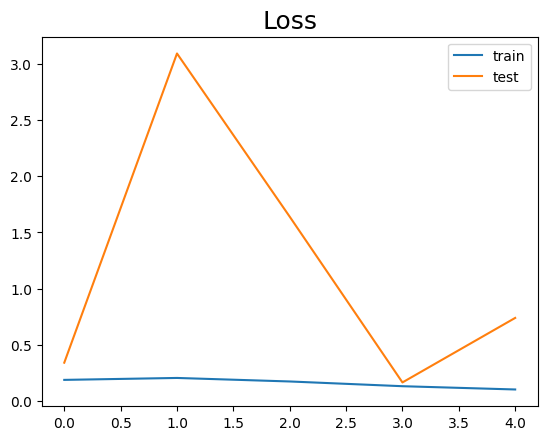

In [32]:
plt.title("Loss", fontdict={'fontsize':18})
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

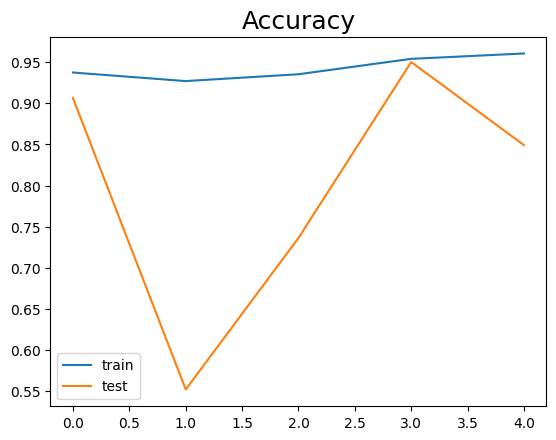

In [33]:
plt.title("Accuracy", fontdict={'fontsize':18})
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.show()

In [34]:
Y_train = []
X_train = []
for data in train_generator:
    X_train.extend(data[0].numpy())
    Y_train.extend(data[1].numpy())
Y_train = np.array(Y_train)
X_train = np.array(X_train)

In [35]:
y_train_pred_prob = ensemble_model.predict(X_train)
y_train_pred = [np.argmax(i) for i in y_train_pred_prob]

106/106 [==============================] - 38s 278ms/step


In [36]:
y_train_pred_prob.shape

(3369, 10)

In [37]:
#function to plot roc-auc curve
def roc_auc_curve(y_scores, y_true):
    # One hot encode the labels in order to plot them
    y_onehot = pd.get_dummies(y_true, columns=classLabels)

    # Create an empty figure, and iteratively add new lines
    # every time we compute a new class
    fig = go.Figure()
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    for i in range(y_scores.shape[1]):
        y_true = y_onehot.iloc[:, i]
        y_score = y_scores[:, i]

        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_score = roc_auc_score(y_true, y_score)

        name = f"{classLabels[i]} (AUC={auc_score:.2f})"
        fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

    fig.update_layout(
        title="ROC Curve",
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        yaxis=dict(scaleanchor="x", scaleratio=1),
        xaxis=dict(constrain='domain'),
        width=900, height=800
    )

    return fig

In [38]:
import seaborn as sb

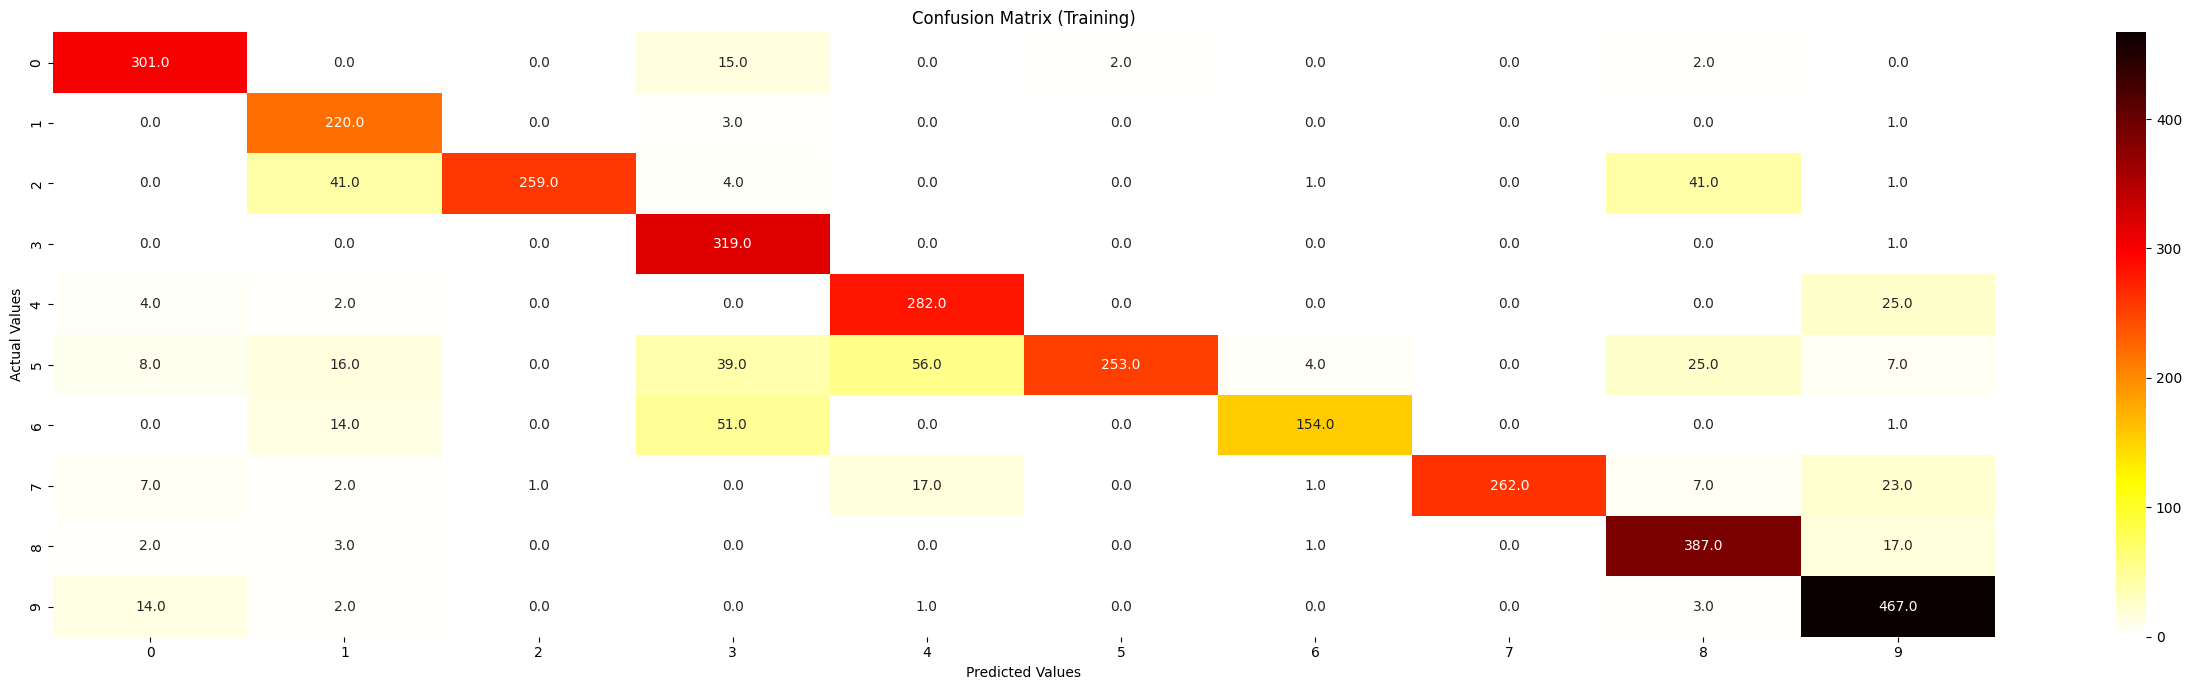

In [39]:
plt.figure(figsize=(25,7))
sb.heatmap(tf.math.confusion_matrix(labels=Y_train,predictions=y_train_pred),annot=True,fmt='.1f', cmap='hot_r')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix (Training)')
plt.tight_layout()
plt.show()

In [40]:
print("Classification Report for Training")
print(classification_report(Y_train, y_train_pred))

Classification Report for Training
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       320
           1       0.73      0.98      0.84       224
           2       1.00      0.75      0.85       347
           3       0.74      1.00      0.85       320
           4       0.79      0.90      0.84       313
           5       0.99      0.62      0.76       408
           6       0.96      0.70      0.81       220
           7       1.00      0.82      0.90       320
           8       0.83      0.94      0.88       410
           9       0.86      0.96      0.91       487

    accuracy                           0.86      3369
   macro avg       0.88      0.86      0.86      3369
weighted avg       0.88      0.86      0.86      3369



In [41]:
roc_auc_curve(y_train_pred_prob, Y_train)
X_test = []
y_test = []
test_generator = tf.keras.utils.image_dataset_from_directory(
        test_path,
        image_size=(IMG_SIZE[0], IMG_SIZE[1]),
        batch_size=batch_size,

          # only data, no labels
        #shuffle=False
        )
for data in test_generator:
    X_test.extend(data[0].numpy())
    y_test.extend(data[1].numpy())
X_test = np.array(X_test)
y_test = np.array(y_test)

Found 1051 files belonging to 10 classes.


In [42]:
y_test_pred_prob = ensemble_model.predict(X_test)
y_test_pred = [np.argmax(i) for i in y_test_pred_prob]

33/33 [==============================] - 12s 373ms/step


In [43]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

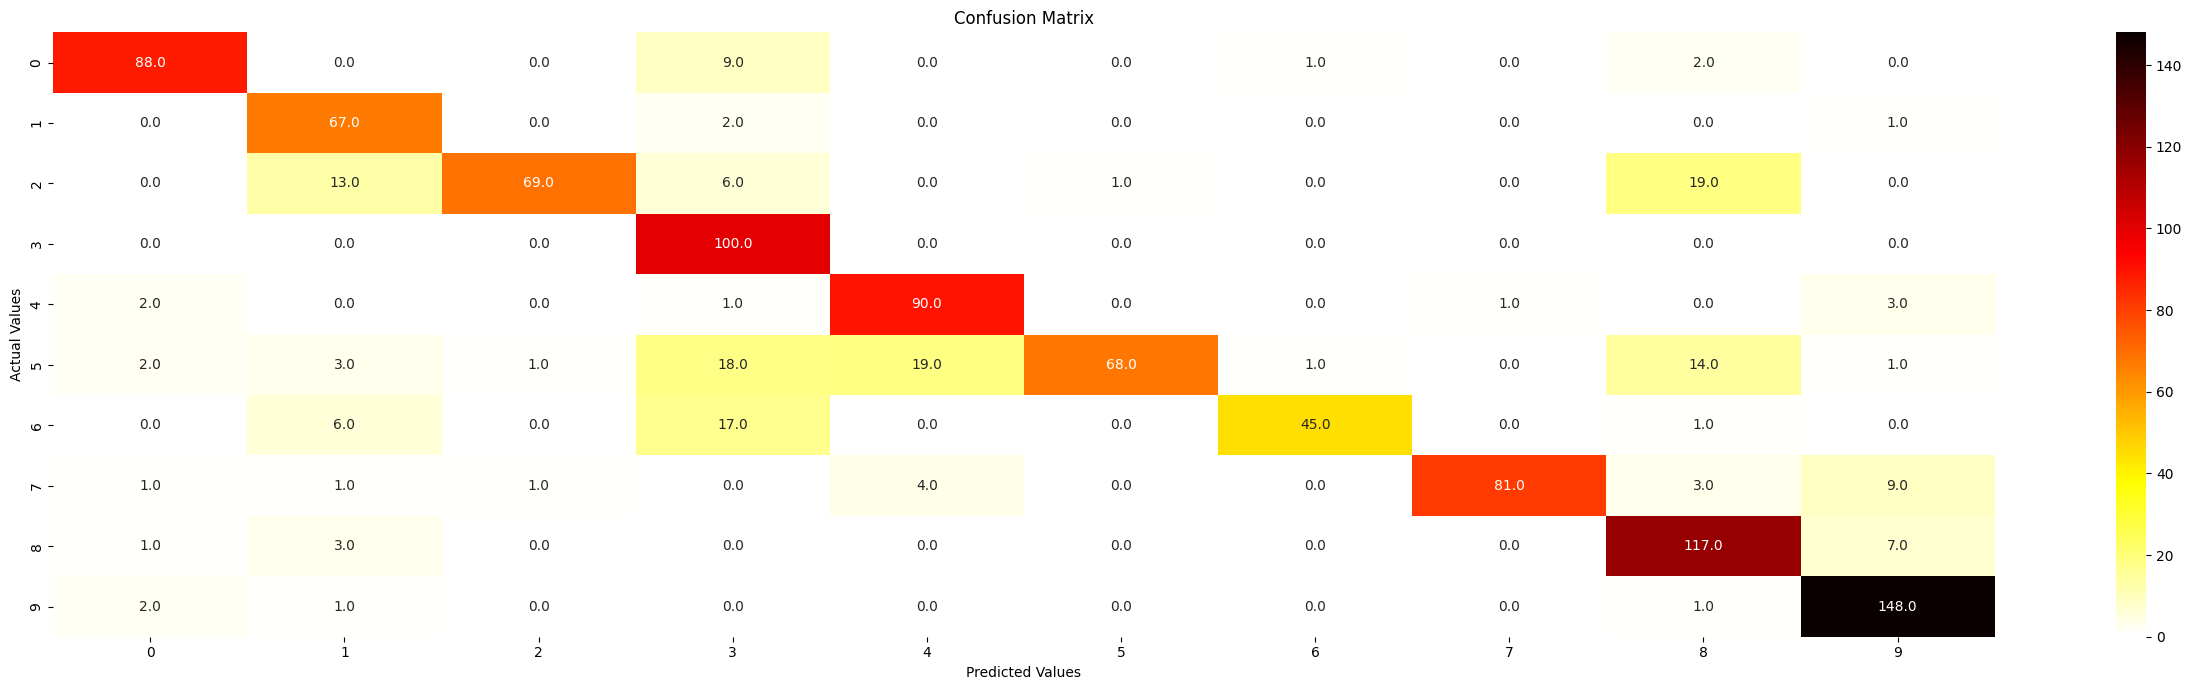

In [44]:
plt.figure(figsize=(25,7))
sb.heatmap(tf.math.confusion_matrix(labels=y_test,predictions=y_test_pred),annot=True,fmt='.1f', cmap='hot_r')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [45]:
print("Classification Report for Test")
print(classification_report(y_test, y_test_pred))

Classification Report for Test
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       100
           1       0.71      0.96      0.82        70
           2       0.97      0.64      0.77       108
           3       0.65      1.00      0.79       100
           4       0.80      0.93      0.86        97
           5       0.99      0.54      0.69       127
           6       0.96      0.65      0.78        69
           7       0.99      0.81      0.89       100
           8       0.75      0.91      0.82       128
           9       0.88      0.97      0.92       152

    accuracy                           0.83      1051
   macro avg       0.86      0.83      0.82      1051
weighted avg       0.86      0.83      0.83      1051



In [46]:
roc_auc_curve(y_test_pred_prob, y_test)

In [47]:
from tensorflow.keras.models import save_model


In [48]:
#MODEL_FILENAMEs=root_path+"model_5fold_Xception03.h5"
#model.save(MODEL_FILENAMEs)

In [49]:
MODEL_FILENAMEs=root_path+"model_5fold_DNMv2_10575325.h5"
ensemble_model.save(MODEL_FILENAMEs)